In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
customer = pd.read_csv('CUSTOMERS.csv')
geo_loc = pd.read_csv('GEO_LOCATION.csv')
order_items = pd.read_csv('ORDER_ITEMS.csv')
order_payments = pd.read_csv('ORDER_PAYMENTS.csv')
order_review = pd.read_csv('ORDER_REVIEW_RATINGS.csv')
orders = pd.read_csv('ORDERS.csv')
products = pd.read_csv('PRODUCTS.csv')
sellers = pd.read_csv('SELLERS.csv')

#### Detailed exploratory analysis

#### a. High level metrics

In [12]:
total_revenue = order_payments['payment_value'].sum()

total_quantity = order_items['order_item_id'].sum()

total_products = products['product_id'].nunique()

total_categories = products['product_category_name'].nunique()

total_sellers = sellers['seller_id'].nunique()

total_locations = geo_loc['geolocation_zip_code_prefix'].nunique()

total_payment_methods = order_payments['payment_type'].nunique()

print(f"Total Revenue: ${total_revenue}")
print(f"Total Quantity: {total_quantity}")
print(f"Total Products: {total_products}")
print(f"Total Categories: {total_categories}")
print(f"Total Sellers: {total_sellers}")
print(f"Total Locations: {total_locations}")
print(f"Total Payment Methods: {total_payment_methods}")


Total Revenue: $16008872.12
Total Quantity: 134936
Total Products: 32951
Total Categories: 71
Total Sellers: 3095
Total Locations: 19015
Total Payment Methods: 5


#### b. New customers acquired every month

In [13]:
month_data = pd.merge(orders, order_payments, on='order_id')

month_data['order_purchase_timestamp'] = pd.to_datetime(month_data['order_purchase_timestamp'])

month_data['order_month_year'] = month_data['order_purchase_timestamp'].dt.to_period('M')

monthly_new_customers = month_data.groupby('order_month_year')['customer_id'].nunique().reset_index()

print(monthly_new_customers)

   order_month_year  customer_id
0           2016-09            3
1           2016-10          324
2           2016-12            1
3           2017-01          800
4           2017-02         1780
5           2017-03         2682
6           2017-04         2404
7           2017-05         3700
8           2017-06         3245
9           2017-07         4026
10          2017-08         4331
11          2017-09         4285
12          2017-10         4631
13          2017-11         7544
14          2017-12         5673
15          2018-01         7269
16          2018-02         6728
17          2018-03         7211
18          2018-04         6939
19          2018-05         6873
20          2018-06         6167
21          2018-07         6292
22          2018-08         6512
23          2018-09           16
24          2018-10            4


#### c. Retention of customers on month on month basis

In [14]:
month_data = pd.merge(orders, order_payments, on='order_id')

month_data['order_purchase_timestamp'] = pd.to_datetime(month_data['order_purchase_timestamp'])

month_data['order_month_year'] = month_data['order_purchase_timestamp'].dt.to_period('M')

monthly_customers = month_data.groupby('order_month_year')['customer_id'].nunique().reset_index()

monthly_customers['retention_rate'] = monthly_customers['customer_id'].pct_change().fillna(0) * 100

print(monthly_customers)


   order_month_year  customer_id  retention_rate
0           2016-09            3        0.000000
1           2016-10          324    10700.000000
2           2016-12            1      -99.691358
3           2017-01          800    79900.000000
4           2017-02         1780      122.500000
5           2017-03         2682       50.674157
6           2017-04         2404      -10.365399
7           2017-05         3700       53.910150
8           2017-06         3245      -12.297297
9           2017-07         4026       24.067797
10          2017-08         4331        7.575758
11          2017-09         4285       -1.062110
12          2017-10         4631        8.074679
13          2017-11         7544       62.902181
14          2017-12         5673      -24.801166
15          2018-01         7269       28.133263
16          2018-02         6728       -7.442564
17          2018-03         7211        7.178954
18          2018-04         6939       -3.772015
19          2018-05 

#### d. Revenues from existing/new customers on month on month basis

In [15]:

merged_data = pd.merge(orders, order_payments, on='order_id')

merged_data['order_purchase_timestamp'] = pd.to_datetime(merged_data['order_purchase_timestamp'])

merged_data['order_month_year'] = merged_data['order_purchase_timestamp'].dt.to_period('M')

merged_data['total_payment_value'] = merged_data.groupby('order_id')['payment_value'].transform('sum')

first_purchase = merged_data.groupby('customer_id')['order_purchase_timestamp'].min().reset_index()

merged_data = pd.merge(merged_data, first_purchase, on='customer_id', suffixes=('', '_new'), how='left')
merged_data['customer_type'] = 'Existing'
merged_data.loc[merged_data['order_purchase_timestamp'] == merged_data['order_purchase_timestamp_new'], 'customer_type'] = 'New'

monthly_revenue = merged_data.groupby(['order_month_year', 'customer_type'])['total_payment_value'].sum().reset_index()

monthly_revenue_pivot = monthly_revenue.pivot(index='order_month_year', columns='customer_type', values='total_payment_value').fillna(0)

print(monthly_revenue_pivot)



customer_type            New
order_month_year            
2016-09               252.24
2016-10             60831.67
2016-12                19.62
2017-01            147797.11
2017-02            308808.88
2017-03            477229.24
2017-04            454146.73
2017-05            636826.85
2017-06            535061.30
2017-07            635750.37
2017-08            708736.55
2017-09            772178.80
2017-10            814910.15
2017-11           1237720.19
2017-12            911251.80
2018-01           1159267.07
2018-02           1033337.24
2018-03           1209070.59
2018-04           1199660.85
2018-05           1197035.60
2018-06           1075963.69
2018-07           1103473.13
2018-08           1057408.02
2018-09              4439.54
2018-10               589.67


#### e. Understand the trends/seasonality of sales, quantity by category, location, month,week, day, time, channel, payment method etc…


In [51]:
# Merge the dataframes
trends_data = pd.merge(order_items, orders, on='order_id')
trends_data = pd.merge(trends_data, products, on='product_id')
trends_data = pd.merge(trends_data, order_payments, on='order_id')
trends_data = pd.merge(trends_data, customer, on='customer_id')

trends_data['order_purchase_timestamp'] = pd.to_datetime(trends_data['order_purchase_timestamp'])
trends_data['order_month_year'] = trends_data['order_purchase_timestamp'].dt.to_period('M')


#### Quantity by cotegory

###### category_sales = trends_data.groupby('product_category_name')['order_item_id'].sum().sort_values(ascending=False)
category_sales.plot(kind='barh', figsize=(12, 12))
plt.title('Quantity Sold by Category')
plt.xlabel('Category')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.show()

####  Sales by Location

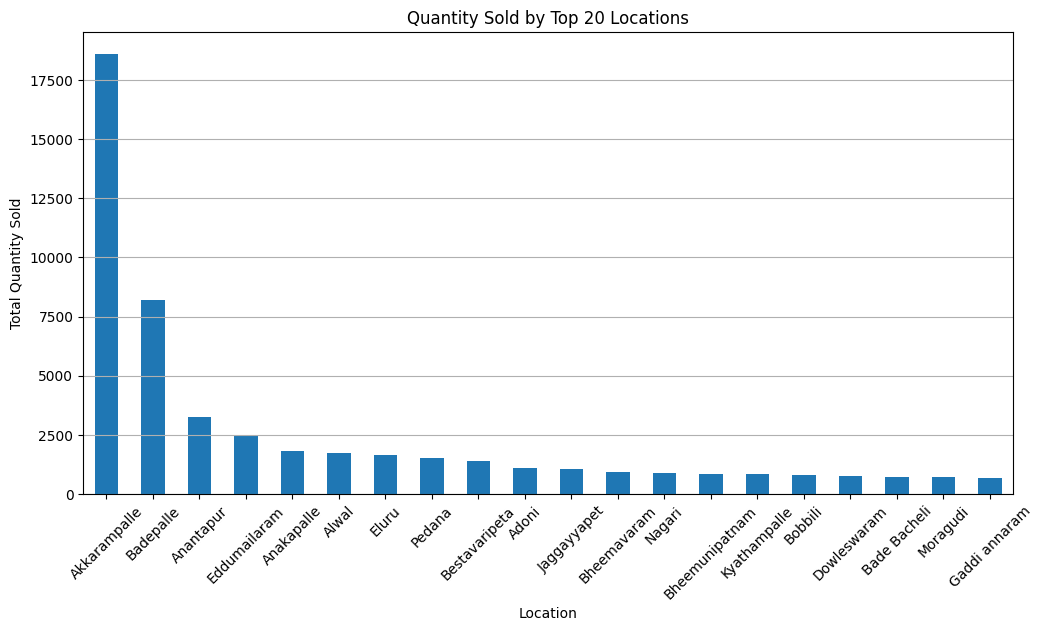

In [53]:
location_sales = trends_data.groupby('customer_city')['order_item_id'].count().sort_values(ascending=False).head(20)
location_sales.plot(kind='bar', figsize=(12, 6))
plt.title('Quantity Sold by Top 20 Locations')
plt.xlabel('Location')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()  

#### Sales by month 

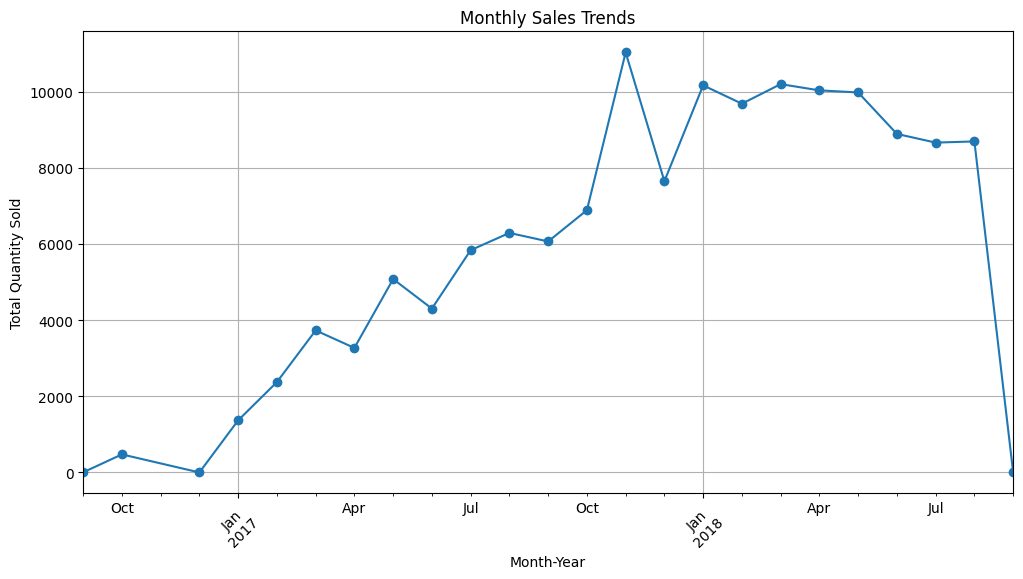

In [70]:
monthly_sales = trends_data.groupby('order_month_year')['order_item_id'].sum()
monthly_sales.plot(kind='line', figsize=(12, 6), marker="o")
plt.title('Monthly Sales Trends')
plt.xlabel('Month-Year')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



#### Sales by Week

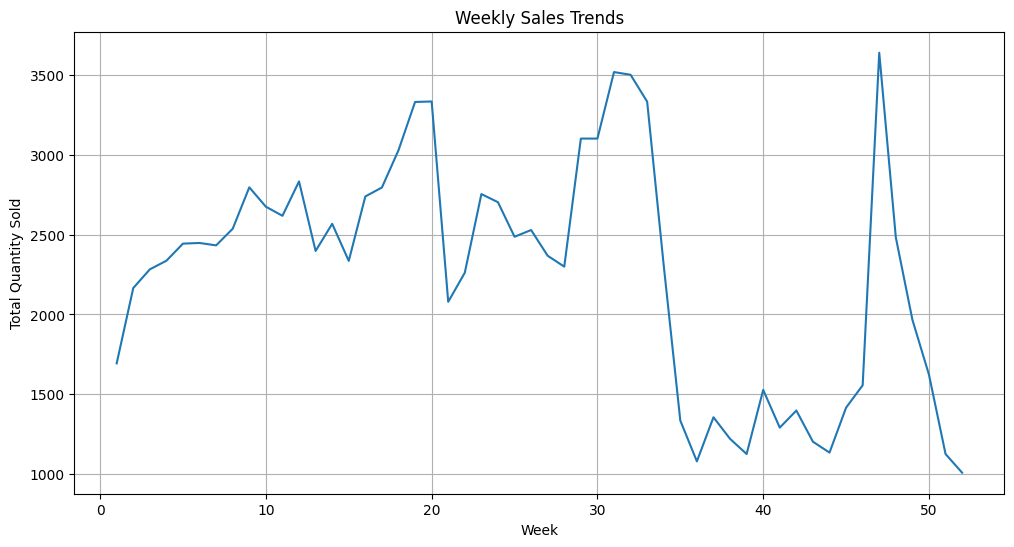

In [55]:
trends_data['order_week'] = trends_data['order_purchase_timestamp'].dt.isocalendar().week
weekly_sales = trends_data.groupby('order_week')['order_item_id'].count()
weekly_sales.plot(kind='line', figsize=(12, 6))
plt.title('Weekly Sales Trends')
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.grid()
plt.show()

#### Sales by Day

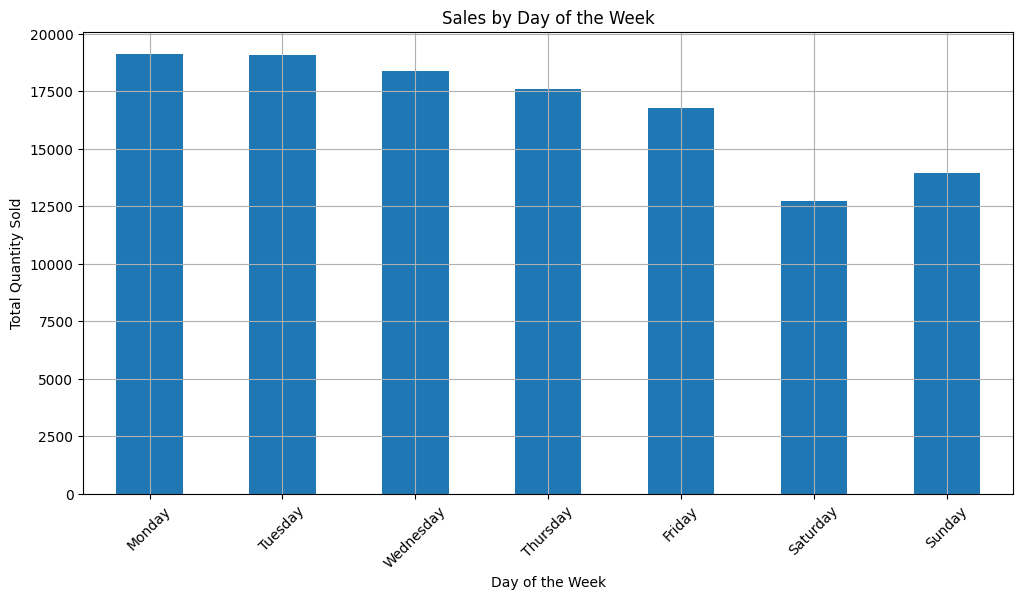

In [56]:
trends_data['order_day_of_week'] = trends_data['order_purchase_timestamp'].dt.day_name()
daily_sales = trends_data.groupby('order_day_of_week')['order_item_id'].count().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
daily_sales.plot(kind='bar', figsize=(12, 6))
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

####  Sales by Time

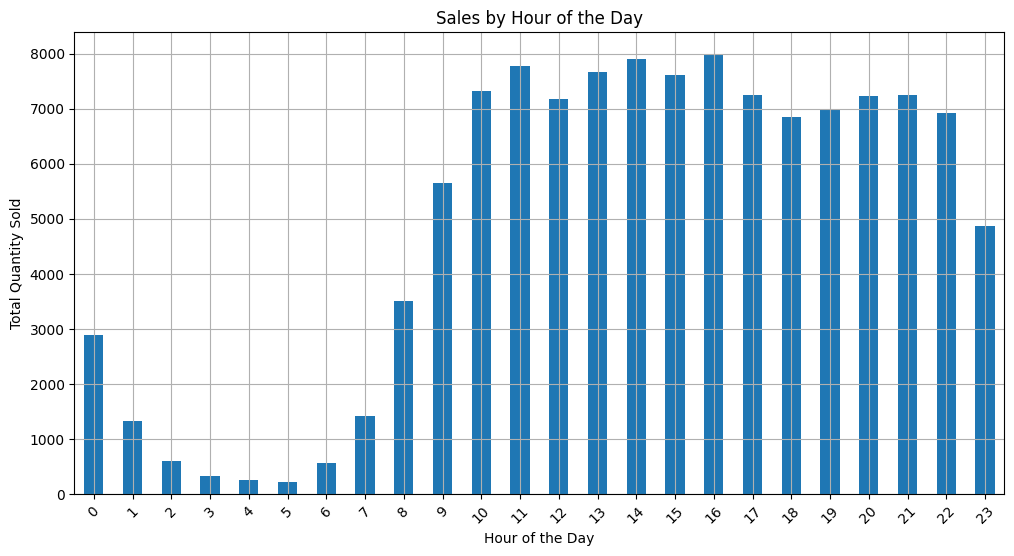

In [60]:
trends_data['order_hour'] = trends_data['order_purchase_timestamp'].dt.hour
hourly_sales = trends_data.groupby('order_hour')['order_item_id'].count()
hourly_sales.plot(kind='bar', figsize=(12, 6))
plt.title('Sales by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Sales by payment_method

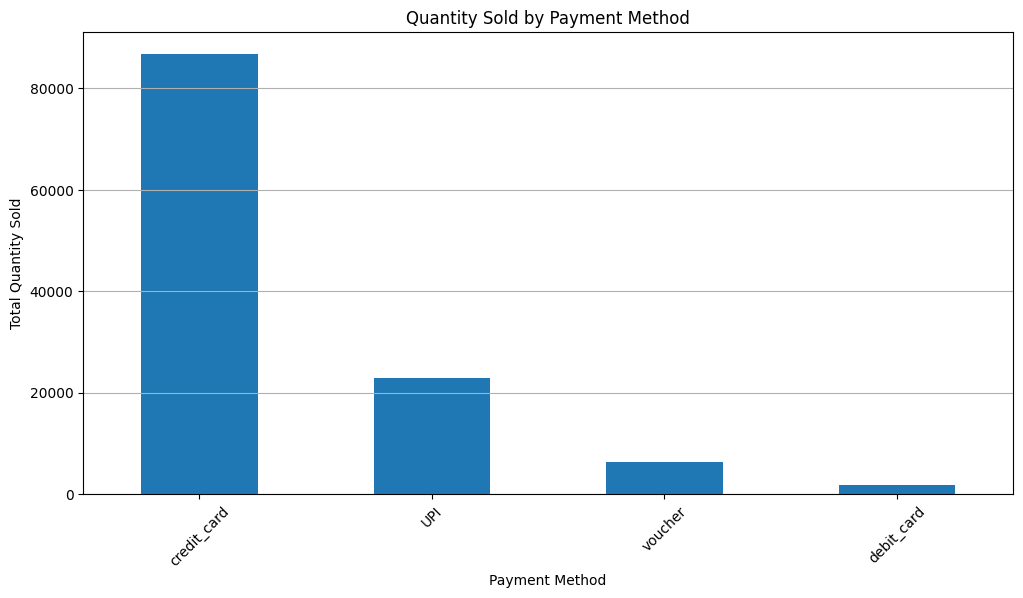

In [23]:
payment_method_sales = trends_data.groupby('payment_type')['order_item_id'].count().sort_values(ascending=False)
payment_method_sales.plot(kind='bar', figsize=(12, 6))
plt.title('Quantity Sold by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### f.Popular Products by month, seller, state, category.

In [24]:
# merging data
trends_data = pd.merge(order_items, orders, on='order_id')
trends_data = pd.merge(trends_data, products, on='product_id')
trends_data = pd.merge(trends_data, order_payments, on='order_id')
trends_data = pd.merge(trends_data, customer, on='customer_id')
trends_data = pd.merge(trends_data, sellers, on='seller_id')

# Convert the order purchase timestamp to datetime
trends_data['order_purchase_timestamp'] = pd.to_datetime(trends_data['order_purchase_timestamp'])
trends_data['order_month'] = trends_data['order_purchase_timestamp'].dt.to_period('M')


#### Popular Products by Month

In [25]:
popular_products_month = trends_data.groupby(['order_month', 'product_id'])['order_item_id'].count().reset_index()
popular_products_month = popular_products_month.sort_values(['order_month', 'order_item_id'], ascending=[True, False]).groupby('order_month').head(5)

popular_products_month = pd.merge(popular_products_month, products[['product_id', 'product_category_name']], on='product_id')
print(popular_products_month)


    order_month                        product_id  order_item_id  \
0       2016-09  c1488892604e4ba5cff5b4eb4d595400              1   
1       2016-09  f293394c72c9b5fafd7023301fc21fc2              1   
2       2016-09  f3c2d01a84c947b078e32bbef0718962              1   
3       2016-10  eba7488e1c67729f045ab43fac426f2e             11   
4       2016-10  85b99d83c60cab5b4d8f927ad35212a1              7   
..          ...                               ...            ...   
105     2018-07  e7cc48a9daff5436f63d3aad9426f28b             25   
106     2018-08  e7cc48a9daff5436f63d3aad9426f28b             75   
107     2018-08  73326828aa5efe1ba096223de496f596             56   
108     2018-08  2bd9b51a9ab079e095aca987845d3266             29   
109     2018-09  b98992ea80b467987a7fbb88e7f2076a              1   

                       product_category_name  
0                            Furniture_Decor  
1                            Furniture_Decor  
2                                  Telepho

#### Popular Products by Seller

In [26]:
popular_products_seller = trends_data.groupby(['seller_id', 'product_id'])['order_item_id'].count().reset_index()
popular_products_seller = popular_products_seller.sort_values(['seller_id', 'order_item_id'], ascending=[True, False]).groupby('seller_id').head(5)

popular_products_seller = pd.merge(popular_products_seller, products[['product_id', 'product_category_name']], on='product_id')
popular_products_seller = pd.merge(popular_products_seller, sellers[['seller_id', 'seller_city', 'seller_state']], on='seller_id')

print(popular_products_seller)


                              seller_id                        product_id  \
0      0015a82c2db000af6aaaf3ae2ecb0532  a2ff5a97bf95719e38ea2e3b4105bce8   
1      001cca7ae9ae17fb1caed9dfb1094831  08574b074924071f4e201e151b152b4e   
2      001cca7ae9ae17fb1caed9dfb1094831  e251ebd2858be1aa7d9b2087a6992580   
3      001cca7ae9ae17fb1caed9dfb1094831  98a8c2fa16d7239c606640f5555768e4   
4      001cca7ae9ae17fb1caed9dfb1094831  0da9ffd92214425d880de3f94e74ce39   
...                                 ...                               ...   
10367  ffff564a4f9085cd26170f4732393726  8f7a3322e1abfed89ac080b0f7364779   
10368  ffff564a4f9085cd26170f4732393726  96aca2f53bcaed6f466449f7fb18ae75   
10369  ffff564a4f9085cd26170f4732393726  c4b925e40f11289063a854c47aaef129   
10370  ffff564a4f9085cd26170f4732393726  c5897f6f2d995196dbb40542439da9b9   
10371  ffff564a4f9085cd26170f4732393726  dbd024d4182504993ad1e3cd2ee9d9e9   

       order_item_id            product_category_name   seller_city  \
0   

#### Popular Products by State

In [27]:
popular_products_state = trends_data.groupby(['customer_state', 'product_id'])['order_item_id'].count().reset_index()
popular_products_state = popular_products_state.sort_values(['customer_state', 'order_item_id'], ascending=[True, False]).groupby('customer_state').head(5)

popular_products_state = pd.merge(popular_products_state, products[['product_id', 'product_category_name']], on='product_id')

print(popular_products_state)


     customer_state                        product_id  order_item_id  \
0    Andhra Pradesh  aca2eb7d00ea1a7b8ebd4e68314663af            346   
1      Chhattisgarh  aca2eb7d00ea1a7b8ebd4e68314663af             31   
2           Gujarat  aca2eb7d00ea1a7b8ebd4e68314663af             52   
3   Jammu & Kashmir  aca2eb7d00ea1a7b8ebd4e68314663af              9   
4            Kerala  aca2eb7d00ea1a7b8ebd4e68314663af             13   
..              ...                               ...            ...   
95      Uttaranchal  1053d2f1df34b526957673f25a1b50e3              2   
96      Uttaranchal  29427de7f8a9ee983d9dbc51cec569b4              2   
97      West Bengal  30ac6df06dc59ad72cf2f158fc2d904c              5   
98      West Bengal  2028bf1b01cafb2d2b1901fca4083222              4   
99      West Bengal  ffaf0af7eebb57c7f262b51ebb05dfd6              4   

   product_category_name  
0        Furniture_Decor  
1        Furniture_Decor  
2        Furniture_Decor  
3        Furniture_Decor  


#### Popular Products by Category

In [28]:
popular_products_category = trends_data.groupby(['product_category_name', 'product_id'])['order_item_id'].count().reset_index()
popular_products_category = popular_products_category.sort_values(['product_category_name', 'order_item_id'], ascending=[True, False]).groupby('product_category_name').head(5)

popular_products_category = pd.merge(popular_products_category, products[['product_id', 'product_category_name']], on='product_id')
print(popular_products_category)


        product_category_name_x                        product_id  \
0    Agro_Industry_And_Commerce  11250b0d4b709fee92441c5f34122aed   
1    Agro_Industry_And_Commerce  423a6644f0aa529e8828ff1f91003690   
2    Agro_Industry_And_Commerce  672e757f331900b9deea127a2a7b79fd   
3    Agro_Industry_And_Commerce  07f01b6fcacc1b187a71e5074199db2d   
4    Agro_Industry_And_Commerce  a0fe1efb855f3e786f0650268cd77f44   
..                          ...                               ...   
343               Watches_Gifts  53b36df67ebb7c41585e8d54d6772e08   
344               Watches_Gifts  a62e25e09e05e6faf31d90c6ec1aa3d1   
345               Watches_Gifts  e0d64dcfaa3b6db5c54ca298ae101d05   
346               Watches_Gifts  a92930c327948861c015c919a0bcb4a8   
347               Watches_Gifts  461f43be3bdf8844e65b62d9ac2c7a5a   

     order_item_id     product_category_name_y  
0               44  Agro_Industry_And_Commerce  
1               19  Agro_Industry_And_Commerce  
2               17  Agro

#### Visualizations

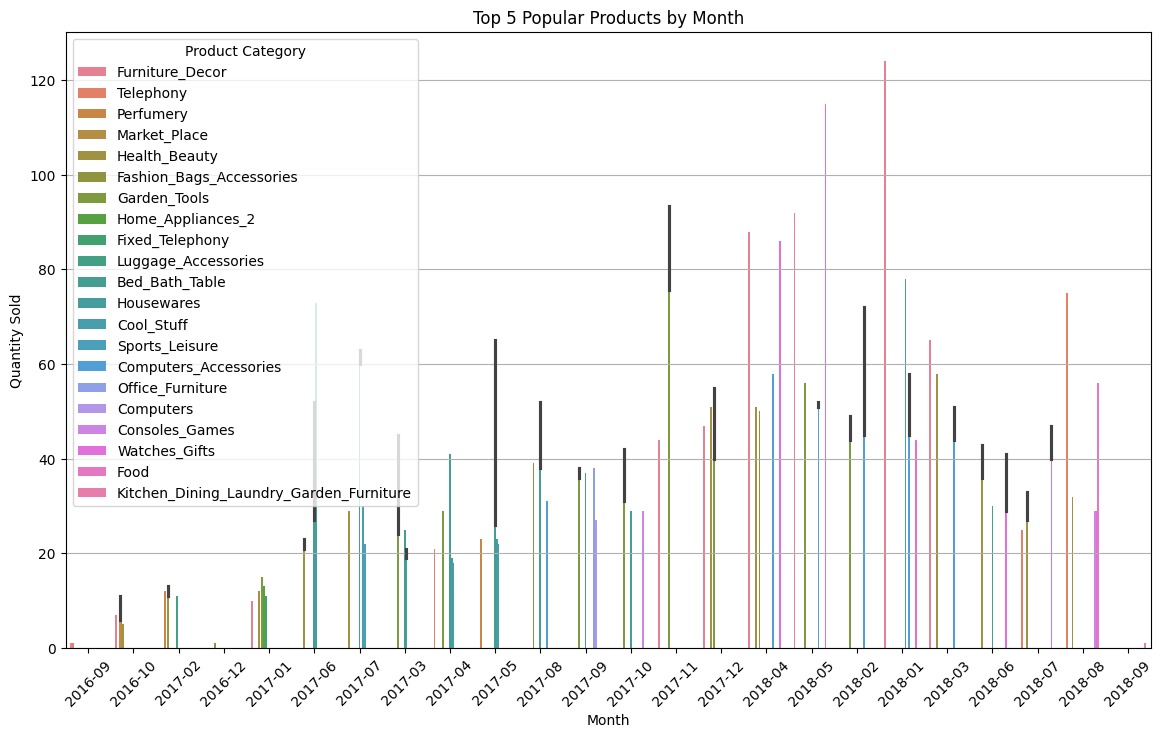

In [29]:
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.barplot(x='order_month', y='order_item_id', hue='product_category_name', data=popular_products_month)
plt.title('Top 5 Popular Products by Month')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.legend(title='Product Category')
plt.grid(axis='y')
plt.show()


#### Popular categories by state, month

In [30]:
trends_data = pd.merge(order_items, orders, on='order_id')
trends_data = pd.merge(trends_data, products, on='product_id')
trends_data = pd.merge(trends_data, customer, on='customer_id')
trends_data['order_purchase_timestamp'] = pd.to_datetime(trends_data['order_purchase_timestamp'])
trends_data['order_month'] = trends_data['order_purchase_timestamp'].dt.to_period('M')


#### Popular Categories by State

In [31]:
# Popular categories by state
popular_categories_state = trends_data.groupby(['customer_state', 'product_category_name'])['order_item_id'].count().reset_index()
popular_categories_state = popular_categories_state.sort_values(['customer_state', 'order_item_id'], ascending=[True, False]).groupby('customer_state').head(5)

print(popular_categories_state)


      customer_state  product_category_name  order_item_id
7     Andhra Pradesh         Bed_Bath_Table           7101
43    Andhra Pradesh          Health_Beauty           6023
65    Andhra Pradesh         Sports_Leisure           5327
39    Andhra Pradesh        Furniture_Decor           5239
15    Andhra Pradesh  Computers_Accessories           4859
...              ...                    ...            ...
1056     West Bengal          Health_Beauty             44
1073     West Bengal              Telephony             34
1041     West Bengal  Computers_Accessories             33
1038     West Bengal         Bed_Bath_Table             32
1071     West Bengal         Sports_Leisure             25

[100 rows x 3 columns]


#### Popular Categories by Month

In [32]:
# Popular categories by month
popular_categories_month = trends_data.groupby(['order_month', 'product_category_name'])['order_item_id'].count().reset_index()
popular_categories_month = popular_categories_month.sort_values(['order_month', 'order_item_id'], ascending=[True, False]).groupby('order_month').head(5)

print(popular_categories_month)


     order_month                    product_category_name  order_item_id
1        2016-09                            Health_Beauty              3
0        2016-09                          Furniture_Decor              2
2        2016-09                                Telephony              1
21       2016-10                          Furniture_Decor             67
23       2016-10                            Health_Beauty             48
...          ...                                      ...            ...
1196     2018-08                           Bed_Bath_Table            658
1233     2018-08                               Housewares            629
1247     2018-08                           Sports_Leisure            475
1225     2018-08                          Furniture_Decor            433
1252     2018-09  Kitchen_Dining_Laundry_Garden_Furniture              1

[110 rows x 3 columns]


####  Visualizations

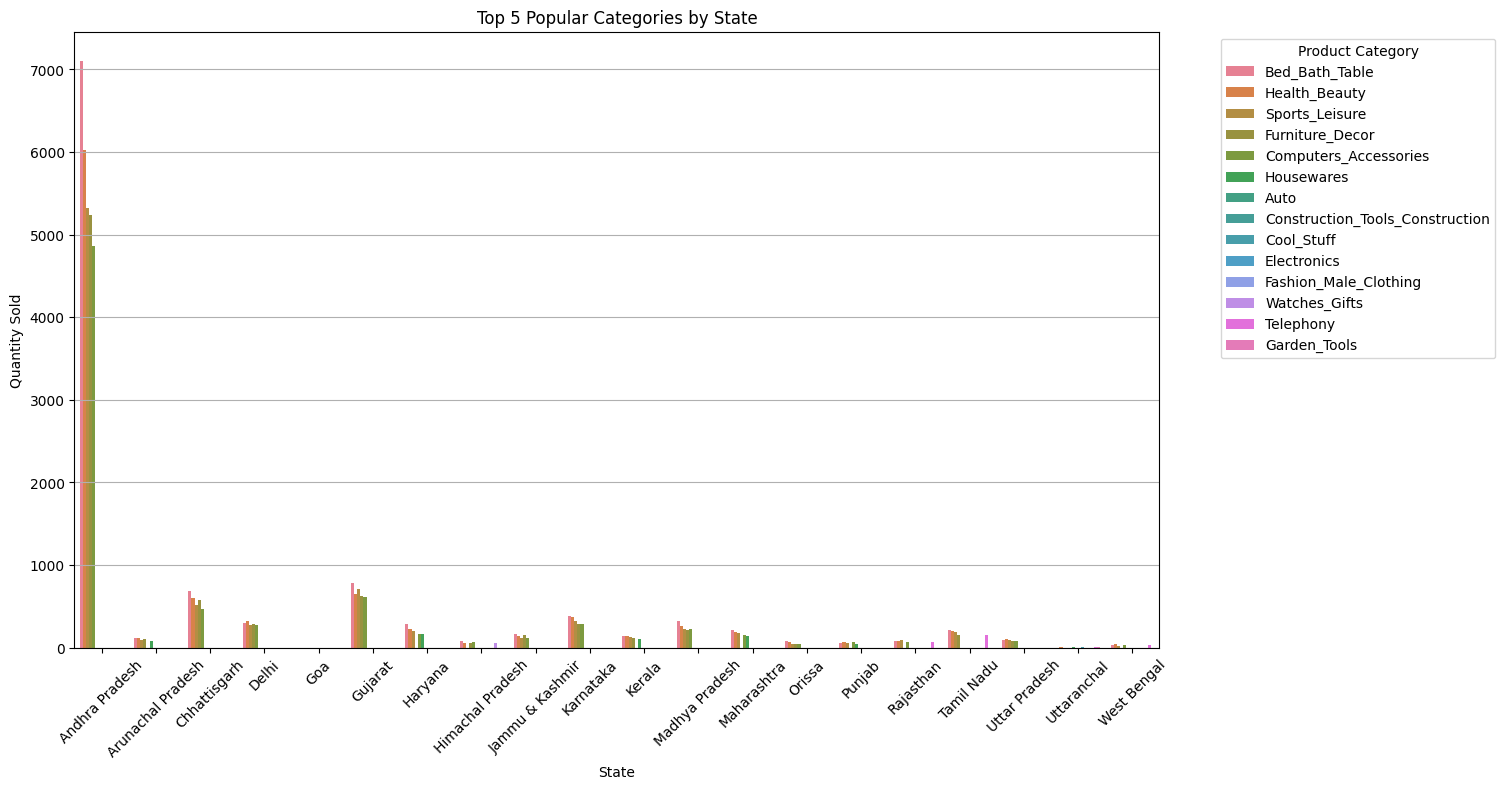

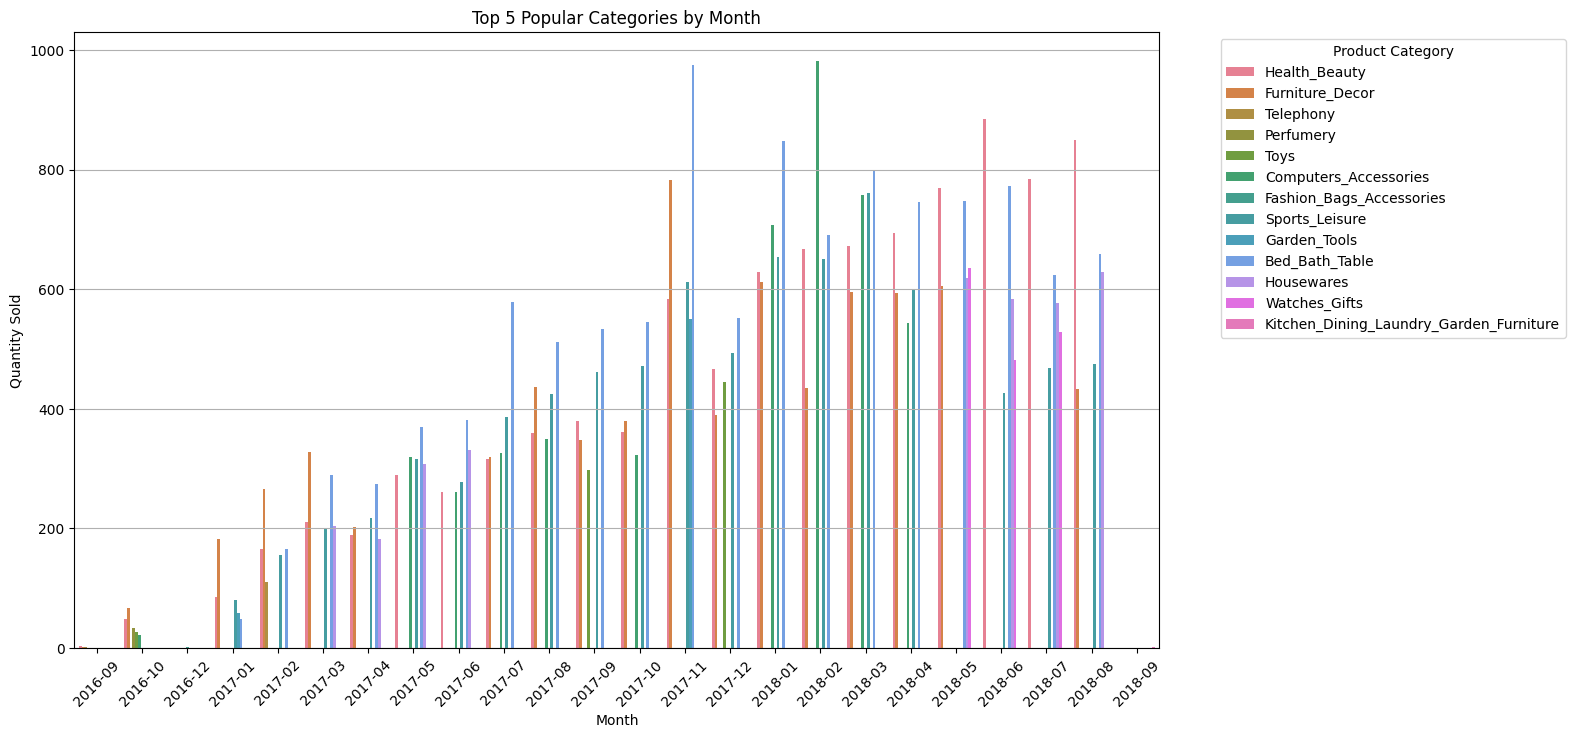

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Visualize popular categories by state
plt.figure(figsize=(14, 8))
sns.barplot(x='customer_state', y='order_item_id', hue='product_category_name', data=popular_categories_state)
plt.title('Top 5 Popular Categories by State')
plt.xlabel('State')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()

# Example: Visualize popular categories by month
plt.figure(figsize=(14, 8))
sns.barplot(x='order_month', y='order_item_id', hue='product_category_name', data=popular_categories_month)
plt.title('Top 5 Popular Categories by Month')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.show()


#### h. List top 10 most expensive products sorted by price

In [34]:
trends_data = pd.merge(order_items, orders, on='order_id')
trends_data = pd.merge(trends_data, products, on='product_id')

trends_data['price'] = pd.to_numeric(trends_data['price'], errors='coerce')

trends_data = trends_data.dropna(subset=['price'])

top_10_expensive_products = trends_data.sort_values(by='price', ascending=False).head(10)

print(top_10_expensive_products[['product_id', 'product_category_name', 'price']])

                              product_id product_category_name    price
37101   489ae2aa008f021502940f251d4cce7f            Housewares  6735.00
112569  69c590f7ffc7bf8db97190b6cb6ed62e             Computers  6729.00
111726  1bdf5e6731585cf01aa8169c7028d6ad                   Art  6499.00
103335  a6492cc69376c469ab6f61d8f44de961      Small_Appliances  4799.00
60252   c3ed642d592594bb648ff4a04cee2747      Small_Appliances  4690.00
99306   259037a6a41845e455183f89c5035f18             Computers  4590.00
81704   a1beef8f3992dbd4cd8726796aa69c53   Musical_Instruments  4399.87
92236   6cdf8fc1d741c76586d8b6b15e9eef30        Consoles_Games  4099.99
102761  dd113cb02b2af9c8e5787e8f1f0722f6        Sports_Leisure  4059.00
98221   6902c1962dd19d540807d0ab8fade5c6         Watches_Gifts  3999.90


#### 2. Performing Customers/sellers Segmentation

    - a. Divide Customers into Groups Based on Revenue    
- Calculate Total Revenue per Customer:

In [35]:
merged_data = pd.merge(orders, order_items, on='order_id')
merged_data = pd.merge(merged_data, order_payments, on='order_id')

customer_revenue = merged_data.groupby('customer_id')['payment_value'].sum().reset_index()
customer_revenue.columns = ['customer_id', 'total_revenue']

# Perform deciles analysis
customer_revenue['revenue_decile'] = pd.qcut(customer_revenue['total_revenue'], 10, labels=False) + 1

print(customer_revenue.head())


                        customer_id  total_revenue  revenue_decile
0  00012a2ce6f8dcda20d059ce98491703         114.74               6
1  000161a058600d5901f007fab4c27140          67.41               3
2  0001fd6190edaaf884bcaf3d49edf079         195.42               8
3  0002414f95344307404f0ace7a26f1d5         179.35               8
4  000379cdec625522490c315e70c7a9fb         107.01               5


#### b. Divide Sellers into Groups Based on Revenue


In [36]:
seller_revenue = merged_data.groupby('seller_id')['payment_value'].sum().reset_index()
seller_revenue.columns = ['seller_id', 'total_revenue']

seller_revenue['revenue_decile'] = pd.qcut(seller_revenue['total_revenue'], 10, labels=False) + 1

print(seller_revenue.head())


                          seller_id  total_revenue  revenue_decile
0  0015a82c2db000af6aaaf3ae2ecb0532        2748.06               7
1  001cca7ae9ae17fb1caed9dfb1094831       48349.22              10
2  001e6ad469a905060d959994f1b41e4f         267.94               3
3  002100f778ceb8431b7a1020ff7ab48f        2445.64               7
4  003554e2dce176b5555353e4f3555ac8         139.38               2


### 2. Cross-Selling Analysis
    - Find Top Product Combinations Selling Together
    - Aggregate Products per Order:


In [37]:
order_products = merged_data.groupby('order_id')['product_id'].apply(list).reset_index()

from itertools import combinations
from collections import Counter

def get_combinations(product_list, n):
    return [tuple(sorted(combo)) for combo in combinations(product_list, n)]

order_products['product_combinations'] = order_products['product_id'].apply(lambda x: get_combinations(x, 2) + get_combinations(x, 3))

all_combinations = [combo for sublist in order_products['product_combinations'] for combo in sublist]
combo_counts = Counter(all_combinations)

combo_counts_df = pd.DataFrame(combo_counts.items(), columns=['combination', 'count'])

top_combinations = combo_counts_df.sort_values(by='count', ascending=False).head(10)

print(top_combinations)

                                             combination  count
8167   (5ddab10d5e0a23acb99acf56b62b3276, ebf9bc6cd60...  18081
8166   (ebf9bc6cd600eadd681384e3116fda85, ebf9bc6cd60...  11480
8168   (5ddab10d5e0a23acb99acf56b62b3276, 5ddab10d5e0...   8820
14101  (0554911df28fda9fd668ce5ba5949695, 0554911df28...   8436
13914  (1aecdb5fa3add74e385f25c6c527a462, 1aecdb5fa3a...   3654
11743  (8d37ee446981d3790967d0268d6cfc81, 8d37ee44698...   2600
9454   (4e53a453045707bbc5febcf5f32097ac, 4e53a453045...   2024
11302  (0449db5eede617c5fd413071d582f038, 0449db5eede...   2024
4482   (11250b0d4b709fee92441c5f34122aed, 11250b0d4b7...   2024
2690   (bdc3291ab242ec1effc8eb0987850268, bdc3291ab24...   1545


### 2. Cross-Selling Analysis Visualization
    - Visualize Top Product Combinations


In [38]:
import warnings
warnings.filterwarnings('ignore')

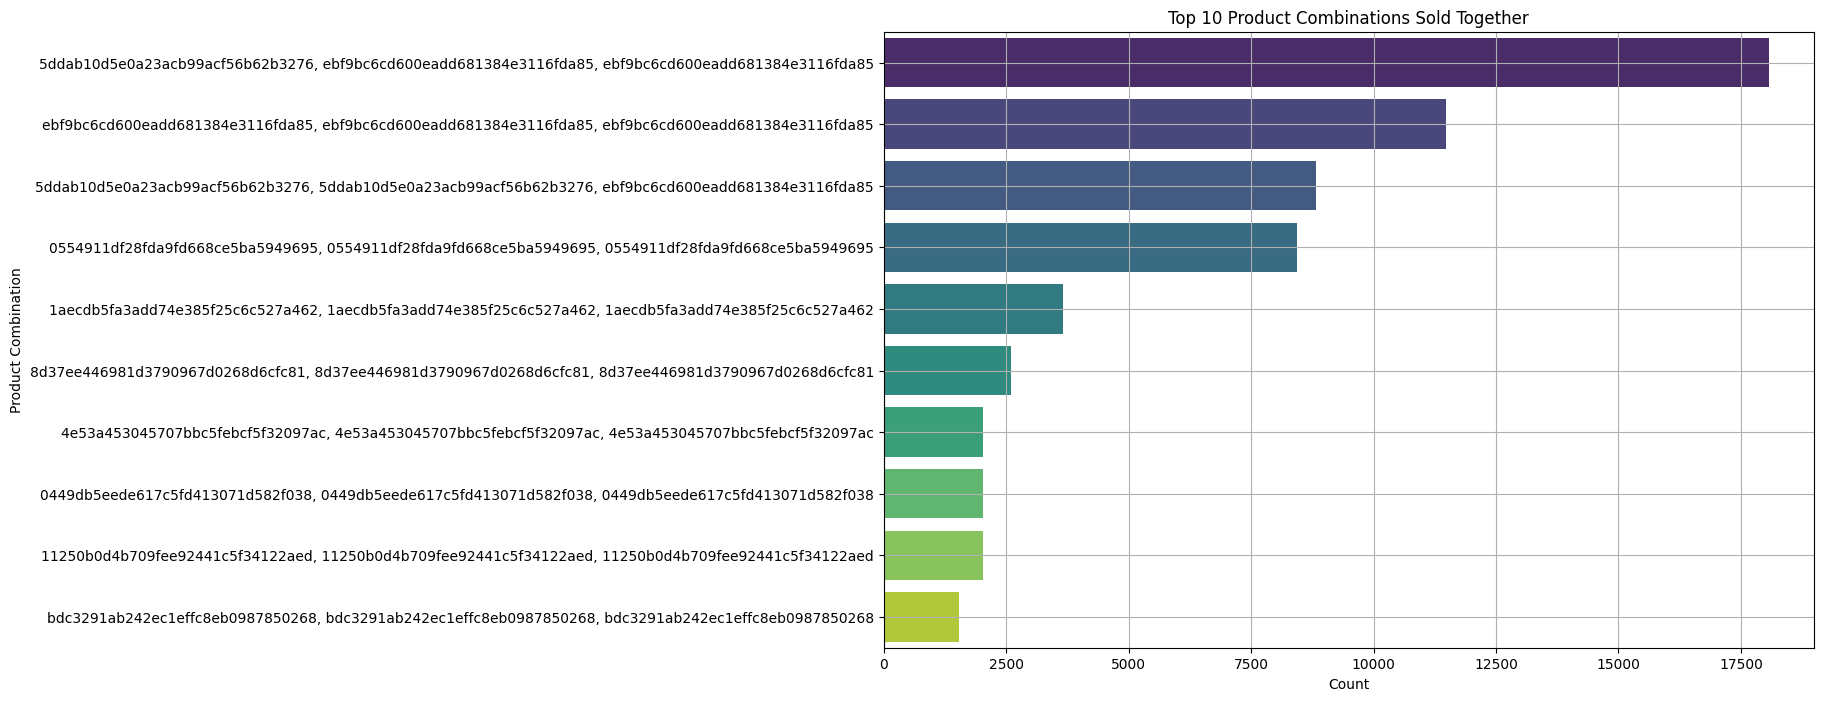

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
top_combinations['combination_str'] = top_combinations['combination'].apply(lambda x: ', '.join(x))

# Plot the top 10 product combinations
plt.figure(figsize=(12, 8))
sns.barplot(data=top_combinations, x='count', y='combination_str', palette='viridis')
plt.title('Top 10 Product Combinations Sold Together')
plt.xlabel('Count')
plt.ylabel('Product Combination')
plt.grid(True)
plt.show()


#### 4. Payment Behaviour

#### a. How customers are paying?

In [40]:
payment_counts = order_payments['payment_type'].value_counts()
payment_percentages = payment_counts / payment_counts.sum() * 100
print("Payment Types and Frequencies:")
print(payment_counts)
print("\nPercentage of Payments by Type:")
print(payment_percentages)


Payment Types and Frequencies:
payment_type
credit_card    76795
UPI            19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

Percentage of Payments by Type:
payment_type
credit_card    73.922376
UPI            19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: count, dtype: float64


#### b. Which payment channels are used by most customers?

In [41]:
merged_data = pd.merge(order_payments, orders[['order_id', 'customer_id']], on='order_id')

customers_per_channel = merged_data.groupby('payment_type')['customer_id'].nunique().sort_values(ascending=False)

print("Number of Customers Using Each Payment Channel:")
print(customers_per_channel)


Number of Customers Using Each Payment Channel:
payment_type
credit_card    76505
UPI            19784
voucher         3866
debit_card      1528
not_defined        3
Name: customer_id, dtype: int64


#### 5. Customer satisfaction towards category & product

#### a. Which categories (top 10) are maximum rated & minimum rated?


In [42]:
merge_1 = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id')
merge_2 = pd.merge(merge_1, order_review[['order_id', 'review_score']], on='order_id')

avg_rating_by_category = merge_2.groupby('product_category_name')['review_score'].mean()

top_10_max_rated_categories = avg_rating_by_category.sort_values(ascending=False).head(10)

top_10_min_rated_categories = avg_rating_by_category.sort_values().head(10)

print("Top 10 Maximum Rated Categories:")
print(top_10_max_rated_categories)

print("\nTop 10 Minimum Rated Categories:")
print(top_10_min_rated_categories)


Top 10 Maximum Rated Categories:
product_category_name
Cds_Dvds_Musicals                        4.642857
Fashion_Childrens_Clothes                4.500000
Books_General_Interest                   4.439421
Books_Imported                           4.400000
Costruction_Tools_Tools                  4.359223
Books_Technical                          4.338290
Luggage_Accessories                      4.309524
Food_Drink                               4.303571
Small_Appliances_Home_Oven_And_Coffee    4.302632
Fashion_Sport                            4.258065
Name: review_score, dtype: float64

Top 10 Minimum Rated Categories:
product_category_name
Security_And_Services     2.500000
Diapers_And_Hygiene       3.256410
Home_Comfort_2            3.366667
Office_Furniture          3.484421
Fashion_Male_Clothing     3.621212
Fixed_Telephony           3.671698
Party_Supplies            3.767442
Fashio_Female_Clothing    3.780000
La_Cuisine                3.785714
Audio                     3.808219
Name

#### b. Which products (top10) are maximum rated & minimum rated?


In [43]:
merge_1 = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id')
merge_2 = pd.merge(merge_1, order_review[['order_id', 'review_score']], on='order_id')
avg_rating_by_product = merge_2.groupby(['product_id', 'product_category_name'])['review_score'].mean()

top_10_max_rated_products = avg_rating_by_product.sort_values(ascending=False).head(10)
top_10_min_rated_products = avg_rating_by_product.sort_values().head(10)

print("\nTop 10 Maximum Rated Products:")
print(top_10_max_rated_products)

print("\nTop 10 Minimum Rated Products:")
print(top_10_min_rated_products)



Top 10 Maximum Rated Products:
product_id                        product_category_name     
00066f42aeeb9f3007548bb9d3f33c38  Perfumery                     5.0
5f2bbb2425de4f4853839fd12fc87d6e  Sports_Leisure                5.0
5f043cb6ec3f7dcaddf80468c523a80d  Fashion_Bags_Accessories      5.0
c5be1408598054572f31046ba67ee86e  Furniture_Decor               5.0
5f09b4a957ee45628820bf10056a1041  Housewares                    5.0
5f0a49e6e539d4e186eeddfd69db9863  Agro_Industry_And_Commerce    5.0
c5ac6d71e1684e3e768495f047b33379  Housewares                    5.0
5f12f6b1738fab26e4a9d7907452c932  Auto                          5.0
5f141d2c6058727659960a250aa940f6  Signaling_And_Security        5.0
5f24a2c5fe04fac8072d899fffa77540  Housewares                    5.0
Name: review_score, dtype: float64

Top 10 Minimum Rated Products:
product_id                        product_category_name     
6026308f343d15d492324e7e35ba5685  Watches_Gifts                 1.0
34502b3a0c6af7c9b8bce8a8af0aa04

#### c. Average rating by location, seller, product, category, month 

#### 1. Average Rating by Location

In [44]:
merge1 = pd.merge(customer,orders,on='customer_id')
merge_location = pd.merge(merge1,order_review, on='order_id')
avg_rating_by_location = merge_location.groupby('customer_city')['review_score'].mean()
print("Average Rating by Location:")
print(avg_rating_by_location)

Average Rating by Location:
customer_city
Aadityana         3.684211
Aambaliyasan      3.500000
Aantaliya         4.000000
Aarambhada        3.772727
Abiramam          5.000000
                    ...   
Zamin Uthukuli    4.000000
Ziauddin Pur      4.014184
Zira              4.500000
Zirakpur          4.500000
Ziro              4.061224
Name: review_score, Length: 4119, dtype: float64


#### 2. Average Rating by Seller:

In [45]:
merge_orders_items = pd.merge(orders, order_items, on='order_id')
merge_orders_items_sellers = pd.merge(merge_orders_items, sellers, on='seller_id')
merge_order_review = pd.merge(merge_orders_items_sellers, order_review, on='order_id')
avg_rating_by_seller = merge_order_review.groupby('seller_id')['review_score'].mean()
print("Average Rating by Seller:")
print(avg_rating_by_seller)


Average Rating by Seller:
seller_id
0015a82c2db000af6aaaf3ae2ecb0532    3.666667
001cca7ae9ae17fb1caed9dfb1094831    3.874477
001e6ad469a905060d959994f1b41e4f    1.000000
002100f778ceb8431b7a1020ff7ab48f    3.982143
003554e2dce176b5555353e4f3555ac8    5.000000
                                      ...   
ffcfefa19b08742c5d315f2791395ee5    1.000000
ffdd9f82b9a447f6f8d4b91554cc7dd3    4.250000
ffeee66ac5d5a62fe688b9d26f83f534    4.214286
fffd5413c0700ac820c7069d66d98c89    3.885246
ffff564a4f9085cd26170f4732393726    2.100000
Name: review_score, Length: 3095, dtype: float64


#### 3. Average Rating by Product:

In [46]:
merge_1 = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id')
merge_product = pd.merge(merge_1, order_review[['order_id', 'review_score']], on='order_id')

avg_rating_by_product = merge_product.groupby('product_id')['review_score'].mean()

print("Average Rating by Product:")
print(avg_rating_by_product)


Average Rating by Product:
product_id
00066f42aeeb9f3007548bb9d3f33c38    5.0
00088930e925c41fd95ebfe695fd2655    4.0
0009406fd7479715e4bef61dd91f2462    1.0
000b8f95fcb9e0096488278317764d19    5.0
000d9be29b5207b54e86aa1b1ac54872    5.0
                                   ... 
fff6177642830a9a94a0f2cba5e476d1    4.5
fff81cc3158d2725c0655ab9ba0f712c    4.0
fff9553ac224cec9d15d49f5a263411f    5.0
fffdb2d0ec8d6a61f0a0a0db3f25b441    5.0
fffe9eeff12fcbd74a2f2b007dde0c58    4.0
Name: review_score, Length: 32951, dtype: float64


#### 4. Average Rating by Category:

In [47]:
merge_1 = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id')
merge_category= pd.merge(merge_1, order_review[['order_id', 'review_score']], on='order_id')

avg_rating_by_category = merge_category.groupby('product_category_name')['review_score'].mean()

print("Average Rating by Category:")
print(avg_rating_by_category)


Average Rating by Category:
product_category_name
Agro_Industry_And_Commerce    4.000000
Air_Conditioning              3.919192
Art                           3.918660
Arts_And_Craftmanship         4.125000
Audio                         3.808219
                                ...   
Stationery                    4.181386
Tablets_Printing_Image        4.048193
Telephony                     3.935604
Toys                          4.138667
Watches_Gifts                 4.002000
Name: review_score, Length: 71, dtype: float64


#### 5. Average Rating by Month:

In [48]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

orders['order_month'] = orders['order_purchase_timestamp'].dt.month

merge_month = pd.merge(order_review, orders, on='order_id')

avg_rating_by_month = merge_month.groupby('order_month')['review_score'].mean()

print("Average Rating by Month:")
print(avg_rating_by_month)


Average Rating by Month:
order_month
1     4.025246
2     3.852179
3     3.821253
4     4.117496
5     4.162633
6     4.221587
7     4.212194
8     4.237877
9     4.161588
10    4.066667
11    3.894446
12    3.998071
Name: review_score, dtype: float64
